In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import csv

In [2]:
#adatok beolvasása, pandas adattábla készítés / importing data, creating pandas dataframe

MU1 = f"05"
MU2 = f"18"
MU3 = f"1"
FILE_NAME1 = f"SimulationResults/sim_mu_" + MU1 + f".csv"
FILE_NAME2 = f"SimulationResults/sim_mu_" + MU2 + f".csv"
FILE_NAME3 = f"SimulationResults/sim_mu_" + MU3 + f".csv"

df1 = pd.read_csv(FILE_NAME1, sep = ',')
df1 = df1.rename(columns = {"NaN": "Time [s]", "NaN.1": "Psi [rad]", "NaN.2": "Psi_max [rad]", "NaN.3": "Torque [Nm]",
                   "NaN.4": "Tow [m]", "NaN.5": "Load [N]", "NaN.6": "Direction (0/1)", "NaN.7": "Section 3/5 (0/1)",
                           "NaN.8": "Mu_calc [1]", "NaN.9": "Mu [1]"})

df2 = pd.read_csv(FILE_NAME2, sep = ',')
df2 = df2.rename(columns = {"NaN": "Time [s]", "NaN.1": "Psi [rad]", "NaN.2": "Psi_max [rad]", "NaN.3": "Torque [Nm]",
                   "NaN.4": "Tow [m]", "NaN.5": "Load [N]", "NaN.6": "Direction (0/1)", "NaN.7": "Section 3/5 (0/1)",
                           "NaN.8": "Mu_calc [1]", "NaN.9": "Mu [1]"})

df3 = pd.read_csv(FILE_NAME3, sep = ',')
df3 = df3.rename(columns = {"NaN": "Time [s]", "NaN.1": "Psi [rad]", "NaN.2": "Psi_max [rad]", "NaN.3": "Torque [Nm]",
                   "NaN.4": "Tow [m]", "NaN.5": "Load [N]", "NaN.6": "Direction (0/1)", "NaN.7": "Section 3/5 (0/1)",
                           "NaN.8": "Mu_calc [1]", "NaN.9": "Mu [1]"})

dataframes = [df1, df2]
df = shuffle(pd.concat(dataframes))
del df1, df2

In [3]:
#Tanítási adatbázis létrehozása / creating training dataset

# fv. az tanítási adatbázis összeállítására / function for creating traning data
def create_dataset(X, y, time_steps=1): 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# tanítási adatok / training data
train_df = df
del train_df["Time [s]"], train_df["Tow [m]"], train_df["Load [N]"], train_df["Mu_calc [1]"]
del train_df["Direction (0/1)"], train_df["Section 3/5 (0/1)"]

#X és y értékek beállítása
X_set = pd.DataFrame()
y_set = pd.DataFrame()
X_set["Psi [rad]"] = train_df["Psi [rad]"]
X_set["Psi_max [rad]"] = train_df["Psi_max [rad]"]
X_set["Torque [Nm]"] = train_df["Torque [Nm]"]
y_set["Mu [1]"] = train_df["Mu [1]"]
X_train, y_train = create_dataset(X_set, y_set)

In [4]:
#CNN modell alkotása / creating the CNN model

model = keras.Sequential()

model.add(keras.layers.Dense(
    units = 1024,
    input_shape = (X_train.shape[1], X_train.shape[2]),
    activation = 'sigmoid'))

model.add(keras.layers.Dense(
    units = 512,
    activation = 'sigmoid'))

model.add(keras.layers.Dense(units = 1))

model.compile(
    optimizer = keras.optimizers.Adam(0.001),
    loss = 'mean_squared_error',
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

early_stopper=keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30, mode = "min", restore_best_weights = True)

In [5]:
#A modell tanítása

EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = 0.1,
    verbose = 0,
    shuffle = True,
    callbacks=[early_stopper]
)

In [6]:
# Validálási adatbázis létrehozása / Creating the validation dataset

valid_df = df3

X_vset = pd.DataFrame()
y_vset = pd.DataFrame()
X_vset["Psi [rad]"] = valid_df["Psi [rad]"]
X_vset["Psi_max [rad]"] = valid_df["Psi_max [rad]"]
X_vset["Torque [Nm]"] = valid_df["Torque [Nm]"]
y_vset["Mu [1]"] = valid_df["Mu [1]"]

X_valid, y_valid = create_dataset(X_vset, y_vset)

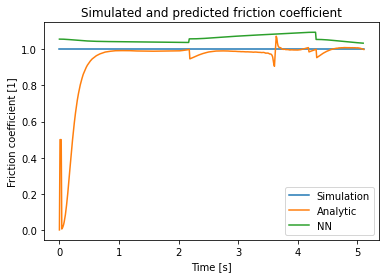

Error of the model / a modell hibája: 0.06070472233945656 [RMSE]


In [7]:
# Validáció / validation
y_pred = model.predict(X_valid)
y = [sor[0][0] for sor in y_pred]

plt.plot(valid_df['Time [s]'], valid_df["Mu [1]"], label = "Simulation")
plt.plot(valid_df['Time [s]'], valid_df["Mu_calc [1]"], label = "Analytic")
plt.plot(valid_df['Time [s]'][0:-1], y, label = "NN")
plt.xlabel("Time [s]")
plt.ylabel("Friction coefficient [1]")
plt.title("Simulated and predicted friction coefficient")
plt.legend()
plt.show()

RMSE = mean_squared_error(valid_df["Mu [1]"][0:-1].values, y, squared = False)
print(f"Error of the model / a modell hibája: {RMSE} [RMSE]")